# The Bradley-Terry model and PyMC for March Madness.

Here, we are going to make an attempt to estimate March Madness teams' skills using the Bradley-Terry model and the PyMC framework.

# 1. Bradley-Terry short overview.

Suppose we have $n$ teams and we have the results of some games they played before. We can find empirical probabilities of some teams winning the other ones. It's okay if all teams played with each other many times. But what can we do if some teams haven't met before?

One of possible solutions is to use the Bradley-Terry model. The model will have n parameters: $\alpha_1, \dots, \alpha_n$ - the teams' skills.

After the parameters' estimation we can estimate the probability that one team beats other one using the next formula:
$$P(i > j| \alpha_1, \dots \alpha_n) = Sigmoid(\alpha_j - \alpha_i)$$

or 

$$logit(P(i > j| \alpha_1, \dots \alpha_n)) = \alpha_i - \alpha_j.$$


As we can see the Bradley-Terry model is an example of the Logistic Regression model. To find $\alpha_1, \dots \alpha_n$ we can use the methods that are used for the Logistic Regression model. The logistic regression parameters are usually estimated using maximum likelihood estimation (MLE).

For the Bradley-Terry model you can find the iterative algorithm to find MLE of $\alpha_1, \dots \alpha_n$ on Wikipedia [[0](https://en.wikipedia.org/wiki/Bradley%E2%80%93Terry_model)].


MLE? That's cool! But what about MAP (maximum a posteriori estimation)?

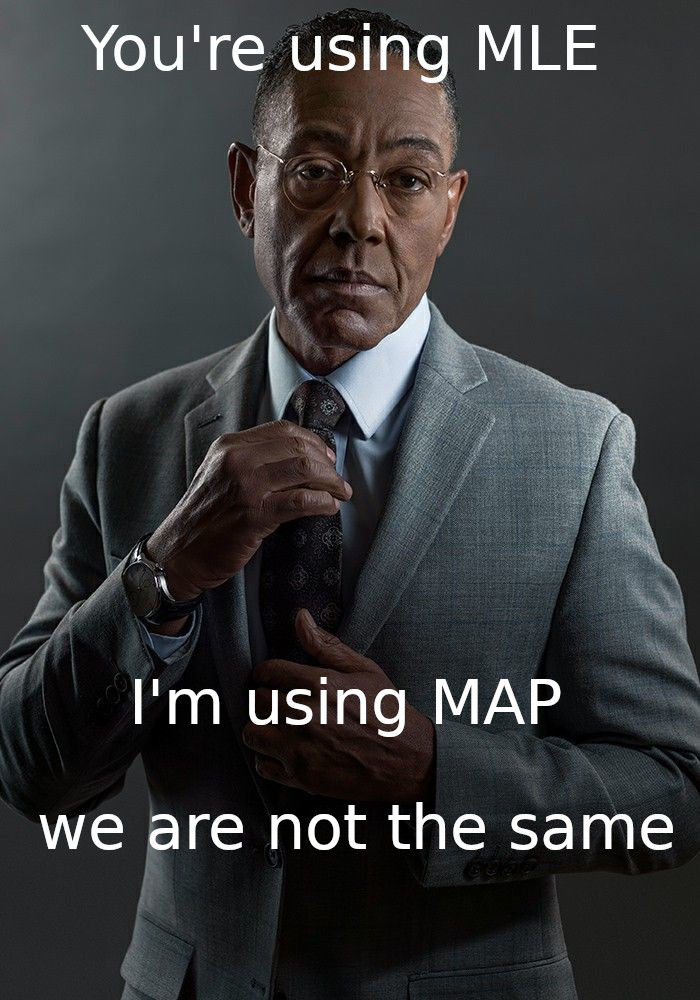

# 2. Sampling stuff.

We are going to asssume that all skills (our model parameters) have a normal distribution as a prior distribution. 

Our task is to find their a posteriori distribution (we have the results of the previous games). There are many approaches to do that. One even can try to find the analitical formula for the distributions we are looking for.

But we are going to use the PyMC [[2]](https://docs.pymc.io/en/latest/learn/examples/pymc_overview.html) framework that will sample from a posteriori distributions for us. All we need to know is how to describe our model using that framework and eventually find the mean of the sampled teams' skills values. Fortunatelly, there is a beautiful blog where everything has been already described [[1]](https://www.pymc-labs.io/blog-posts/pymc-stan-benchmark/), so we need just to reimplement it for our data.

# 3. Seeking for the teams' skills.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import arviz as az

from abc import ABC, abstractmethod
from sklearn.metrics import log_loss

az.style.use("arviz-darkgrid")


REGULAR_DF_PATH = '../input/mens-march-mania-2022/MDataFiles_Stage1/MRegularSeasonDetailedResults.csv'
TOURNEY_DF_PATH = '../input/mens-march-mania-2022/MDataFiles_Stage1/MNCAATourneyDetailedResults.csv'
TOURNEY_SEEDS = '../input/mens-march-mania-2022/MDataFiles_Stage1/MNCAATourneySeeds.csv'
SPELLINGS_PATH = '../input/mens-march-mania-2022/MDataFiles_Stage2/MTeamSpellings.csv'

SEASON = 2022
TRAIN_SEASONS_NUM = 2

So, let's try to estimate the skills for the men's teams that competed this year. Our train data is the previous two regular seasons' games, test - the play-off.

In [ ]:
train_df = pd.read_csv(REGULAR_DF_PATH)
train_df = train_df[np.logical_and(train_df.Season >= SEASON - TRAIN_SEASONS_NUM + 1, train_df.Season <= SEASON)]

In [ ]:
win_lose_games = [    
    # 32
    ('gonzaga', 'georgia st.'),
    ('memphis', 'boise st'),
    ('new mexico', 'uconn'),
    ('arkansas', 'vermont'),
    ('notre dame', 'alabama'),
    ('texas tech', 'montana st'),
    ('michigan st', 'davidson'),
    ('duke', 'cs fullerton'),
    ('arizona', 'wright st'),
    ('tcu', 'seton hall'),
    ('houston', 'uab'),
    ('illinois', 'chattanooga'),
    ('tennessee', 'longwood'),
    ('michigan', 'colorado st'),
    ('ohio st', 'loyola-chicago'),
    ('villanova', 'delaware'),
    ('baylor', 'norfolk st'),
    ('north carolina', 'marquette'),
    ("st mary's ca", 'indiana'),
    ('ucla', 'akron'),
    ('purdue', 'yale'),
    ('texas', 'virginia tech'),
    ('murray st', 'san francisco'),
    ("st peter's", 'kentucky'),
    ('kansas', 'tx southern'),
    ('creighton', 'san diego'),
    ('richmond', 'iowa'),
    ('providence', 'south dakota'),
    ('wisconsin', 'colgate'),
    ('iowa st', 'lsu'),
    ('miami fl', 'usc'),
    ('auburn', 'jacksonville'),
    
    # 16
    ('gonzaga', 'memphis'),
    ('arkansas', 'new mexico'),
    ('texas tech', 'notre dame'),
    ('duke', 'michigan st'),
    ('arizona', 'tcu'),
    ('houston', 'illinois'),
    ('michigan', 'tennessee'),
    ('villanova', 'ohio st'),
    ('north carolina', 'baylor'),
    ('ucla', "st mary's ca"),
    ('purdue', 'texas'),
    ("st peter's", 'murray st'),
    ('kansas', 'creighton'),
    ('providence', 'richmond'),
    ('iowa st', 'wisconsin'),
    ('miami fl', 'auburn'),
        
    # 8
    ('arkansas', 'gonzaga'),
    ('duke', 'texas tech'),
    ('houston', 'arizona'),
    ('villanova', 'michigan'),
    ('north carolina', 'ucla'),
    ("st peter's", 'purdue'),
    ('kansas', 'providence'),
    ('miami fl', 'iowa st'),
        
    # 4
    ('duke', 'arkansas'),
    ('north carolina', "st peter's"),
    ('villanova', 'houston'),
    ('kansas', 'miami fl'),
    
    # 2
    ('north carolina', 'duke'),
    ('kansas', 'villanova'),
        
    # 1
    ('kansas', 'north carolina')]

In [ ]:
spellings_df = pd.read_csv(SPELLINGS_PATH, encoding='iso-8859-1')


winner_ids_test = []
loser_ids_test = []
for team_1, team_2 in win_lose_games:
    id1 = spellings_df[spellings_df.TeamNameSpelling == team_1].TeamID.values[0]
    id2 = spellings_df[spellings_df.TeamNameSpelling == team_2].TeamID.values[0]
    
    winner_ids_test.append(id1)
    loser_ids_test.append(id2)
    
    
test_df = pd.DataFrame({'WTeamID': winner_ids_test, 'LTeamID': loser_ids_test})

First, we need to change ids of all teams, so they starts from 0 (for convenience).

In [ ]:
winner_ids, loser_ids = train_df['WTeamID'].values, train_df['LTeamID'].values
all_ids = list(set(winner_ids).union(loser_ids))
id_to_ordinal = dict(zip(all_ids, range(len(all_ids))))


new_winner_ids = np.array([id_to_ordinal[i] for i in winner_ids])                     
new_loser_ids = np.array([id_to_ordinal[i] for i in loser_ids])

Now we build the model. Except for the normal distribution prior we also introduce a new variable *team_sd* with the HalfNormal distribution. We are going to multiply skills by that positive variable. As the author of [[1]](https://www.pymc-labs.io/blog-posts/pymc-stan-benchmark/) wrote we do this because we don't know the range where all skills lie in (the difference of the skills between two teams may have different magnitudes that would affect our probability prediction). So, let's sample!

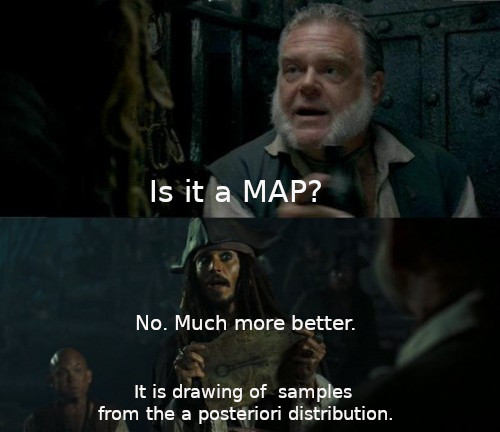

In [ ]:
bt_model = pm.Model()
with bt_model:
    
    # Priors for unknown model parameters
    team_sd = pm.HalfNormal("team_sd", sigma=1.0)
    team_skills_raw = pm.Normal("team_skills_raw", 0.0, sigma=1.0, shape=(len(all_ids),))
    
    
    # This also is an unknown parameter, but it fully determined by the priors above
    team_skills = pm.Deterministic("team_skills", team_skills_raw * team_sd)
    
    # the same story but we don't use the Detereministic wrapper, so we will not see this variable in our results
    logit_skills = team_skills[new_winner_ids] - team_skills[new_loser_ids]
    
    # all data is provided in a way that the left team always beats the right
    games_results = np.ones(new_winner_ids.shape[0])
    
    # we are solving the Binary classification problem
    win_lik = pm.Bernoulli("win_lik", logit_p=logit_skills, observed=games_results)
    
    trace = pm.sample(return_inferencedata=False)

PyMC conducts several experiments sampling distributions for our model (they are called chains thanks to Markov chain Monte Carlo that is used under the hood). We can compare how different the results of those experiments were.

In [ ]:
with bt_model:
    az.plot_trace(trace)

The plots we've got are difficult to analyze :) But we can see that the lines of the same color (dotted and not-dotted ones) are close to each other, so all our experiments have led us to the same result.   

In [ ]:
with bt_model:
    idata = az.from_pymc3(trace)    

Now, it's time to get the skills.

In [ ]:
team_skills = idata.posterior["team_skills"].mean(axis=0).mean(axis=0)

id_to_skills = {idx: team_skills[ordinal] for idx, ordinal in id_to_ordinal.items()}

# 4. Validation.

So far, we have found the teams' skills. Let's use them!

In [ ]:
class AbstractEstimator(ABC):
 
    @abstractmethod
    def predict(self, ids_a, ids_b):
        pass
    
    
class BtEstimator(AbstractEstimator):
    def __init__(self, id_to_skill):
        self.id_to_skill = id_to_skill
    
    ''' Returns the prob that 'a' team wins team 'b'. '''
    def predict(self, ids_a:np.ndarray, ids_b:np.ndarray) -> np.array:
        skill_a = np.array([self.id_to_skill[i] for i in ids_a])
        skill_b = np.array([self.id_to_skill[i] for i in ids_b])
        
        return np.exp(skill_a) / (np.exp(skill_a) + np.exp(skill_b))
    

def validate(val_df, estimator: AbstractEstimator):
    ids_a, ids_b = val_df['WTeamID'].values, val_df['LTeamID'].values 
    return log_loss(np.ones(len(val_df), dtype=np.int8), estimator.predict(ids_a, ids_b), labels=[0, 1])

In [ ]:
estimator = BtEstimator(id_to_skills)
print(f'{SEASON} log_loss MAP: ', validate(test_df, estimator))

That's not so bad. It could be somewhere in the middle of the leaderboard. At least we can see that the model works.

# 5. More complex model.

Let's try to make life for PyMC more complicated adding some extra data to the model. Here we are going to use 538 rating. Our model is going to solve something like that:

$$logit(P(i > j| \alpha_1, \dots \alpha_n)) = \alpha_i - \alpha_j + \sigma * (rating_i - rating_j),$$

where $rating_i$ - 538 rating of i-th team and $\sigma$ is importance of the rating in our model.

In [ ]:
# some teams are not presented in the rating
DEFAULT_538_RATING = 55
RATING_538_PATH = '../input/ncaa-men-538-team-ratings/538ratingsMen.csv'

In [ ]:
def get_538_rating(season):
    rating_df = pd.read_csv(RATING_538_PATH)    
    rating_name = '538rating'

    rating_df = rating_df[rating_df.Season == season]
    id_to_rating = dict(zip(rating_df.TeamID.values, rating_df[rating_name].values))    
    return id_to_rating


class BtEstimatorWithExtraRating(AbstractEstimator):
    def __init__(self, id_to_skill, id_to_rating, rating_coef, default_rating):
        self.id_to_skill = id_to_skill
        self.id_to_rating = id_to_rating
        self.rating_coef = rating_coef
        self.default_rating = default_rating
        
    ''' Returns the prob that 'a' team wins team 'b'. '''
    def predict(self, ids_a:np.ndarray, ids_b:np.ndarray) -> np.array:
        skill_a = np.array([self.id_to_skill[i] for i in ids_a])
        skill_b = np.array([self.id_to_skill[i] for i in ids_b])
        rating_a = self.rating_coef * np.array([self.id_to_rating[i] if i in self.id_to_rating.keys() else self.default_rating for i in ids_a])
        rating_b = self.rating_coef * np.array([self.id_to_rating[i] if i in self.id_to_rating.keys() else self.default_rating for i in ids_b])
        
        return np.exp(skill_a + rating_a) / (np.exp(skill_a + rating_a) + np.exp(skill_b + rating_b))

In [ ]:
id_to_rating = get_538_rating(SEASON)
ratings = np.array([id_to_rating[i] if i in id_to_rating.keys() else DEFAULT_538_RATING for i in all_ids])
    
bt_model = pm.Model()
with bt_model:
    # we don't know how imoprtant the rating is, so let the model find out this
    rating_sd = pm.HalfNormal("rating_sd", sigma=1.0)
    team_sd = pm.HalfNormal("team_sd", sigma=1.0)
    team_skills_raw = pm.Normal("team_skills_raw", 0.0, sigma=1.0, shape=(len(all_ids),))
    
    team_skills = pm.Deterministic("team_skills", team_skills_raw * team_sd)

    logit_skills = team_skills[new_winner_ids] - team_skills[new_loser_ids] + rating_sd * (ratings[new_winner_ids] - ratings[new_loser_ids])
    
    lik = pm.Bernoulli("win_lik", logit_p=logit_skills, observed=np.ones(new_winner_ids.shape[0]))

    trace = pm.sample(return_inferencedata=False)

In [ ]:
with bt_model:
    az.plot_trace(trace)

Let's validate our brand new model!

In [ ]:
with bt_model:
    idata = az.from_pymc3(trace)    

team_skills = idata.posterior["team_skills"].mean(axis=0).mean(axis=0)
rating_sd = idata.posterior["rating_sd"].mean(axis=0).mean(axis=0).item()
id_to_skills = {idx: team_skills[ordinal] for idx, ordinal in id_to_ordinal.items()}


estimator = BtEstimatorWithExtraRating(id_to_skills, id_to_rating, rating_sd, DEFAULT_538_RATING)

print(f'{SEASON} log_loss MAP and extra rating: ', validate(test_df, estimator))

The rating hasn't helped us much. But it was a nice endeavour.

# 6. Conclusion.

The Bradley-Terry model can be used as a baseline model in the competitions like March Madness. Also the skill estimations it provides can be used as a feature for other models. Also we considered a possible extension for our model. It didn't work so well, but one can try to find other possible extensions.

Some useful links:

0. Wikipedia: https://en.wikipedia.org/wiki/Bradley%E2%80%93Terry_model

1. Bradley Terry model example: https://www.pymc-labs.io/blog-posts/pymc-stan-benchmark/

2. PyMC tutorial: https://docs.pymc.io/en/latest/learn/examples/pymc_overview.html

3. The creation of this notebook was inspired by https://www.kaggle.com/c/mens-machine-learning-competition-2019/discussion/90254

# Thank you for your attention! Let the Bayes be with you :)

# 7. Bonus. What if I didn't overcomplicate things.

In [ ]:
from sklearn.linear_model import LogisticRegression

# thanks to https://stackoverflow.com/questions/29831489/convert-array-of-indices-to-1-hot-encoded-numpy-array
def one_hot(ids, max_id):
    res = np.zeros((len(ids), max_id + 1))
    res[np.arange(len(ids)), ids] = 1
    return res

In [ ]:
X_wins = one_hot(new_winner_ids, max(all_ids)) - one_hot(new_loser_ids, max(all_ids))
X_loses = one_hot(new_loser_ids, max(all_ids)) - one_hot(new_winner_ids, max(all_ids))
X = np.vstack([X_wins, X_loses])
y = np.hstack([np.ones(len(train_df)), np.zeros(len(train_df))])

In [ ]:
lm = LogisticRegression(fit_intercept=False)
lm.fit(X, y)
team_skills = lm.coef_.reshape(-1)

In [ ]:
id_to_skills = {idx: team_skills[ordinal] for idx, ordinal in id_to_ordinal.items()} 
estimator = BtEstimator(id_to_skills)
print(f'{SEASON} log_loss with MLE: ', validate(test_df, estimator))

Yeah... That's better :)